<a href="https://colab.research.google.com/github/besherh/DM-ML/blob/master/transfer_learning_inception_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-gpu-2.0-preview
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 345.6MB 55kB/s 
     |████████████████████████████████| 3.2MB 32.1MB/s 
     |████████████████████████████████| 440kB 41.6MB/s 
     |████████████████████████████████| 686kB 3.3MB/s 


In [0]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-dev20190617
Eager mode:  True
Hub version:  0.4.0
GPU is available


Load CIFAR 10

In [0]:
data,ds_info = tfds.load("cifar10", with_info= True, as_supervised=True)

cifar10_train,cifar10_test = data["test"],data["train"]

num_classes = ds_info.features['label'].num_classes
training_examples = ds_info.splits['train'].num_examples
testing_examples = ds_info.splits['test'].num_examples

  
print('Number of classes in CIFAR10 is {}'.format(num_classes))
print('Number of training examples in CIFAR10 is {}'.format(training_examples))
print('Number of validation examples in CIFAR10 is {}'.format(testing_examples))



W0617 17:18:24.347084 140308854052736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:247: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.
Number of classes in CIFAR10 is 10
Number of training examples in CIFAR10 is 50000
Number of validation examples in CIFAR10 is 10000


In [0]:
IMG_SHAPE = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))/255.0
  return  image, label

BATCH_SIZE = 32

  

train_batches = cifar10_train.shuffle(training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = cifar10_test.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
cifar10_example = train_batches.take(1)
cifar10_example


<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:

#"https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE,3), trainable=False)

In [0]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes,activation = 'softmax')
])

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

EPOCHS = 15
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)



Epoch 1/15


W0617 17:20:35.485632 140308854052736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


313/313 [==============================] - 157s 502ms/step - loss: 1.3954 - accuracy: 0.6222 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
313/313 [==============================] - 141s 452ms/step - loss: 1.0136 - accuracy: 0.7359 - val_loss: 0.9864 - val_accuracy: 0.7437
Epoch 3/15
313/313 [==============================] - 141s 451ms/step - loss: 0.9217 - accuracy: 0.7643 - val_loss: 0.9696 - val_accuracy: 0.7489
Epoch 4/15
313/313 [==============================] - 141s 451ms/step - loss: 0.8631 - accuracy: 0.7863 - val_loss: 0.9638 - val_accuracy: 0.7506
Epoch 5/15
313/313 [==============================] - 141s 452ms/step - loss: 0.8193 - accuracy: 0.8024 - val_loss: 0.9646 - val_accuracy: 0.7514
Epoch 6/15
313/313 [==============================] - 141s 451ms/step - loss: 0.7842 - accuracy: 0.8151 - val_loss: 0.9687 - val_accuracy: 0.7507
Epoch 7/15
313/313 [==============================] - 141s 451ms/step - loss: 0.7548 - accuracy: 0.8253 - val_loss: 0.9747 - va

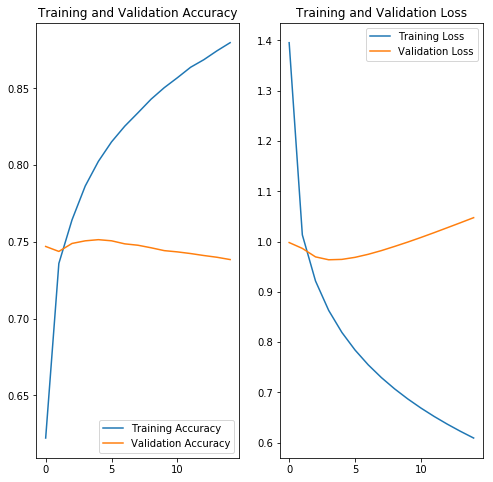

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#model 2

In [0]:
model2 = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes,activation = 'softmax')
])
model2.summary()
model2.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), 
  loss=tf.keras.losses.sparse_categorical_crossentropy,
  metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

EPOCHS = 80
history2 = model2.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)



Epoch 1/80
313/313 [==============================] - 141s 449ms/step - loss: 0.8482 - accuracy: 0.7876 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/80
313/313 [==============================] - 140s 448ms/step - loss: 0.8303 - accuracy: 0.7903 - val_loss: 0.9843 - val_accuracy: 0.7449
Epoch 3/80
313/313 [==============================] - 140s 448ms/step - loss: 0.8148 - accuracy: 0.7960 - val_loss: 0.9896 - val_accuracy: 0.7452
Epoch 4/80
313/313 [==============================] - 140s 448ms/step - loss: 0.8045 - accuracy: 0.8040 - val_loss: 0.9948 - val_accuracy: 0.7453
Epoch 5/80
313/313 [==============================] - 141s 449ms/step - loss: 0.7980 - accuracy: 0.8047 - val_loss: 0.9852 - val_accuracy: 0.7513
Epoch 6/80
313/313 [==============================] - 141s 450ms/step - loss: 0.7922 - accuracy: 0.8060 - val_loss: 0.9934 - val_accuracy: 0.7484
Epoch 7/80
313/313 [==============================] - 141s 449ms/step - loss: 0.7876 - accuracy: 0.8077 - val_loss: 

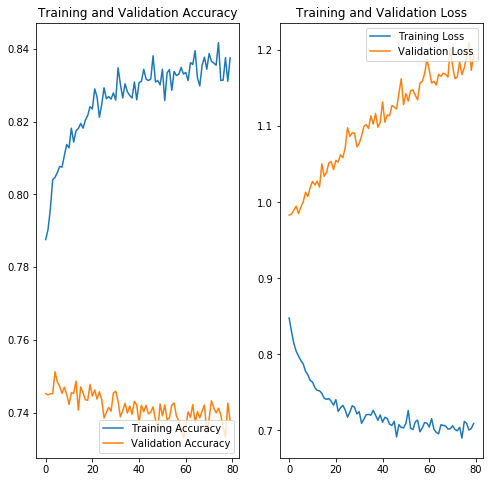

In [0]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range2 = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()